In [116]:
%matplotlib inline
from IPython.display import display

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy import stats
import sys
import math

## Find and parse real and baseline layout files
Files are not neatly organized 

In [117]:
dataset_id = "" # Program argument

In [118]:
rectangles_dirs = [d[0] for d in os.walk("./rectangles/")]
rectangles_dirs.sort()
baseline_dirs = [d for d in rectangles_dirs if dataset_id in d and "baseLine" in d]
real_dirs = [d for d in rectangles_dirs if dataset_id in d and "baseLine" not in d]

In [119]:
def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

In [120]:
technique_ids = []
rectangles = {}
for i in range(len(real_dirs)):
    # Match technique name from path
    match = re.match("./rectangles/(\w+)", real_dirs[i])
    technique_id = ''
    if match:
        technique_id = match.group(1)
        technique_ids.append(technique_id)
    else:
        print("Invalid path: ", real_dirs[i])
    
    real_rectangles_paths = [os.path.join(real_dirs[i], f) for f in os.listdir(real_dirs[i]) if os.path.isfile(os.path.join(real_dirs[i], f))]
    real_rectangles_paths = natural_sort(real_rectangles_paths)
    baseline_rectangles_paths = [os.path.join(baseline_dirs[i], f) for f in os.listdir(baseline_dirs[i]) if os.path.isfile(os.path.join(baseline_dirs[i], f))]
    baseline_rectangles_paths = natural_sort(baseline_rectangles_paths)
    
    dataframes = []
    # Real i matches with Baseline i-1 
    # Revision 0 doesn't have a Baseline, but we'll need the Real layout for Aspect Ratio statistics 
    
    real_df = pd.read_csv(real_rectangles_paths[0], header=None)
    column_names = ['id', 'rx', 'ry', 'rw', 'rh']
    real_df.columns = column_names
    real_df.set_index('id', inplace=True)
    dataframes.append(real_df)
    
    # Read remaining revisions
    for j in range(len(real_rectangles_paths) - 1):
        # print(real_rectangles_paths[j+1], baseline_rectangles_paths[j])
        # Read Real
        column_names = ['id', 'rx', 'ry', 'rw', 'rh']
        real_df = pd.read_csv(real_rectangles_paths[j+1], header=None)
        real_df.columns = column_names
        real_df.set_index('id', inplace=True)
        # Read Baseline
        # print(baseline_rectangles_paths[j])
        column_names = ['id', 'bx', 'by', 'bw', 'bh']
        baseline_df = pd.read_csv(baseline_rectangles_paths[j], header=None)
        baseline_df.columns = column_names
        baseline_df.set_index('id', inplace=True)
        
        df = pd.concat([real_df, baseline_df], axis=1, join='inner')
        dataframes.append(df)
        
    rectangles[technique_id] = dataframes
    

In [121]:
# display(rectangles["StripTreeMap"][95].head())
# display(rectangles["StripTreeMap"][96].head())
n_revisions = len(rectangles["ApproximationTreeMap"])

# Compute Aspect Ratios

In [122]:
def styleBoxplot(bp, ax, n_revisions):
    
    def get_ax_size(ax):
        bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        width, height = bbox.width, bbox.height
        width *= fig.dpi
        height *= fig.dpi
        return width, height
    
    for box in bp['boxes']:
        # change outline color
        box.set(color='#1b9e77',
                linewidth=0,
                path_effects=[pe.Stroke(linewidth=0.1, foreground='#1b9e77'), pe.Normal()],
                facecolor='#1b9e77')
        box.set_zorder(10)
    for i, median in enumerate(bp['medians']):
        median.set(color='#1445FF', 
                   linewidth=2, 
                   solid_capstyle="butt", 
                   ms=(get_ax_size(ax)[0])/(n_revisions))
        median.set_zorder(11)
        #median.set_xdata([i + 1 - 0.3, i + 1 + 0.3])
    for whisker in bp['whiskers']:
        whisker.set(color='#CCCCCC',
                    linestyle='-', 
                    solid_capstyle="butt")
        whisker.set_path_effects([pe.PathPatchEffect(edgecolor='#CCCCCC', linewidth=((get_ax_size(ax)[0])/(n_revisions))*1.08,
                                                 facecolor='black')])
    for cap in bp['caps']:
        cap.set(color='#FFFFFF', linewidth=0)
        
    # Set only 3 ticks on x
    ax.set_xticks([1, n_revisions / 2, n_revisions], minor=False)
    ax.set_xticklabels([1, int(n_revisions / 2), n_revisions], fontdict=None, minor=False)
    
    # Remove extra spines and ticks
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_zorder(100)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', which='both', top='off', direction='out')
    ax.tick_params(axis='y', which='both', right='off', left='on', direction='out')

In [123]:
technique_ids

['ApproximationTreeMap',
 'HilbertTreeMap',
 'IncrementalLayout',
 'MooreTreeMap',
 'PivotByMiddle',
 'PivotBySize',
 'PivotBySplit',
 'SliceAndDice',
 'SpiralTreeMap',
 'SquarifiedTreeMap',
 'StripTreeMap']

ApproximationTreeMap
HilbertTreeMap
IncrementalLayout
MooreTreeMap
PivotByMiddle
PivotBySize
PivotBySplit
SliceAndDice
SpiralTreeMap
SquarifiedTreeMap
StripTreeMap


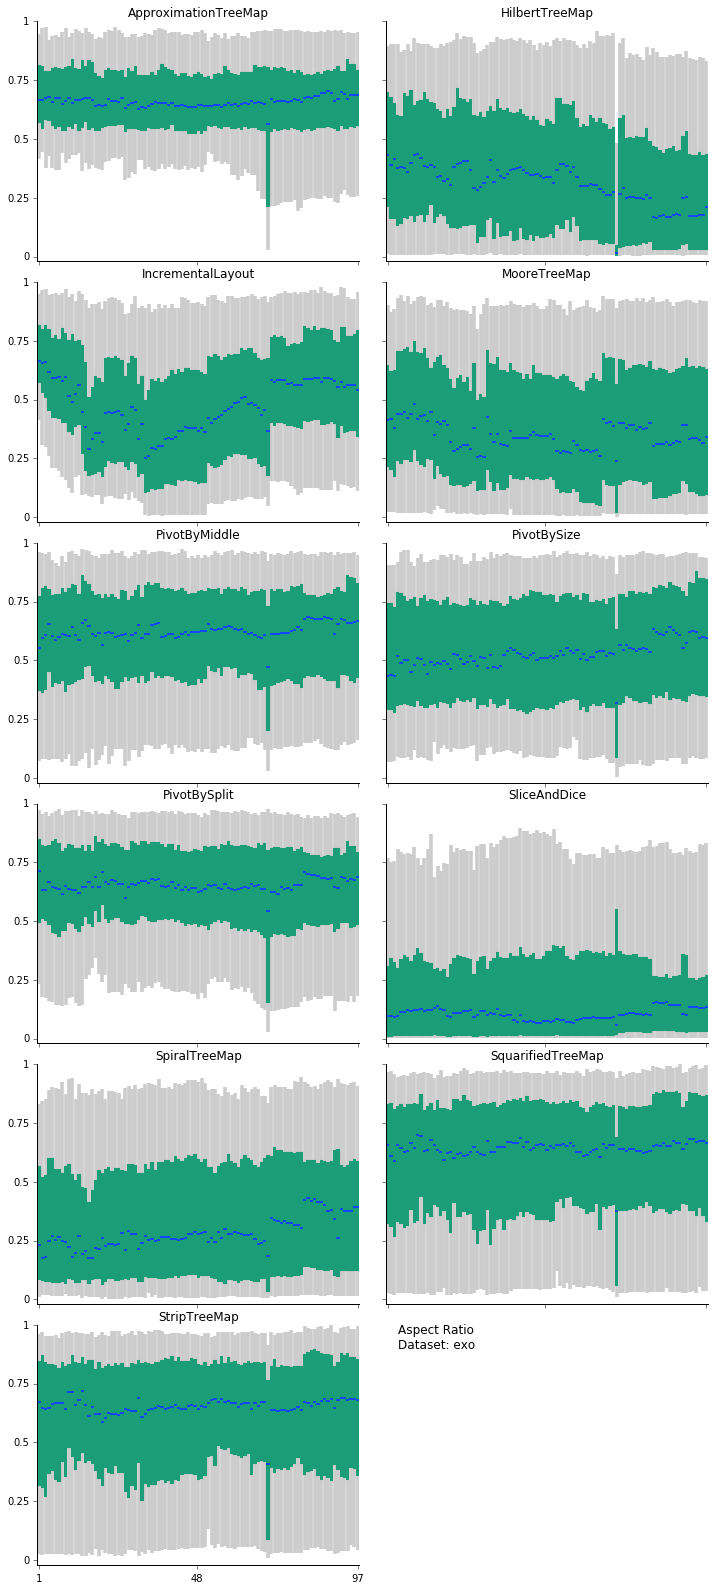

In [124]:
nrow = 6
ncol = 2
fig, axs = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(10, 22))
#fig.delaxes(axs[5, 1])
fig.tight_layout()

for i, ax in enumerate(fig.axes):
    if i != 11:
        technique = technique_ids[i]
        ax.set_title(technique)
        print(technique)

        data = []
        for revision in range(n_revisions):
            df = rectangles[technique][revision]
            ars = df[['rw', 'rh']].min(axis=1) / df[['rw', 'rh']].max(axis=1)
            data.append(ars)
        bp = ax.boxplot(data, whis=[5, 95], showfliers=False, patch_artist=True, widths=1);

        ax.set_ylim(ymin=-0.02, ymax=1)
        ax.set_yticks([0, .25, .5, .75, 1], minor=False)
        ax.set_yticklabels([0, .25, .5, .75, 1], fontdict=None, minor=False)
        styleBoxplot(bp, ax, len(data))
    

s = "Aspect Ratio\nDataset: " + dataset_id
fig.axes[11].text(4, .9, s, fontsize=12)
# Remove extra spines and ticks
fig.axes[11].spines['top'].set_visible(False)
fig.axes[11].spines['bottom'].set_visible(False)
fig.axes[11].spines['left'].set_visible(False)
fig.axes[11].spines['right'].set_visible(False)
fig.axes[11].tick_params(axis='x', which='both', top='off', bottom='off', labelbottom='off')
fig.axes[11].tick_params(axis='y', which='both', right='off', left='off')

fig.savefig('./boxplots/svg/' + dataset_id + "_ar" + '.svg')
fig.savefig('./boxplots/png/' + dataset_id + "_ar" + '.png')


# Compute Baseline Stability

In [125]:
def point_distance(x1, y1, x2, y2):
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

def corner_travel(*args):
    x1, y1, w1, h1, x2, y2, w2, h2 = args
    if math.isnan(w1):
        # 2 times the hypotenuse -- growth from center
        return 2 * math.sqrt(w2 ** 2 + h2 ** 2)
    elif math.isnan(w2):
        return 2 * math.sqrt(w1 ** 2 + h1 ** 2)
    else:
        return point_distance(x1, y1, x2, y2)   \
            + point_distance(x1 + w1, y1, x2 + w2, y2)   \
            + point_distance(x1, y1 + h1, x2, y2 + h2)   \
            + point_distance(x1 + w1, y1 + h1, x2 + w2, y2 + h2)

            
def baseline_ratio_stability(df0, df1, bl1):
    
    # Create dataframes with real coordinates and real-baseline coordinates
    dfr = pd.merge(df0, df1, how='inner', left_index=True, right_index=True)
    dfb = pd.merge(df0, bl1, how='inner', left_index=True, right_index=True)
    
    r_m = dfr.apply(lambda r: corner_travel(*list(r)), axis=1)
    b_m = dfb.apply(lambda r: corner_travel(*list(r)), axis=1)
    

    results = pd.concat([r_m, b_m], axis=1, join='inner')
    results.columns = ['real', 'baseline']
    results['stab'] = results['baseline'] / results[['baseline', 'real']].max(axis=1)
    # display(results)
    return results['stab'].values.tolist()


def baseline_diff_stability(df0, df1, bl1):
    # Normalize by 4 * hypotenuse
    base_width = (df0['rx'] + df1['rw']).max()
    base_height = (df0['ry'] + df1['rh']).max()
    norm = 4 * math.sqrt(base_width ** 2 + base_height ** 2)

    # Create dataframes with real coordinates and real-baseline coordinates
    dfr = pd.merge(df0, df1, how='inner', left_index=True, right_index=True)
    dfb = pd.merge(df0, bl1, how='inner', left_index=True, right_index=True)
    
    r_m = dfr.apply(lambda r: corner_travel(*list(r)) / norm, axis=1)
#     r_m = dfr.apply(lambda r: corner_travel(*list(r)), axis=1)
    b_m = dfb.apply(lambda r: corner_travel(*list(r)) / norm, axis=1)
#     b_m = dfb.apply(lambda r: corner_travel(*list(r)), axis=1)
    
#     fig, axs = plt.subplots(1, 1, sharex=True, sharey=True)
#     fig.axes[0].set_title(len(dfr))
#     fig.axes[0].scatter(dfr, dfb)
#     fig.show()

#     fig, ax = plt.subplots()
#     ax.hist(r_m, alpha=0.5, color="red", label='real')
#     ax.hist(b_m, alpha=0.5, color="blue", label='baseline')
#     ax.legend(loc='upper right')
    
    results = pd.concat([r_m, b_m], axis=1, join='inner')
    results.columns = ['real', 'baseline']
    results['stab'] = results['real'] - results['baseline']
    results['stab'] = results[['stab']].clip(0, 1)
    # display(results)
    return results['stab'].values.tolist()
        
#     r0 = df0[['rx', 'ry', 'rw', 'rh']].values.tolist()
#     r1 = df1[['rx', 'ry', 'rw', 'rh']].values.tolist()    
#     b1 = df1[['bx', 'by', 'bw', 'bh']].values.tolist()
#     bs = []
#     for i in range(len(r0)):
#         rm = corner_travel(r0[i], r1[i])
#         bm = corner_travel(r0[i], b1[i])
#         print("r: {:.2f} \t\t b: {:.2f}".format(rm, bm))
        

ApproximationTreeMap
HilbertTreeMap
IncrementalLayout
MooreTreeMap
PivotByMiddle
PivotBySize
PivotBySplit
SliceAndDice
SpiralTreeMap
SquarifiedTreeMap
StripTreeMap


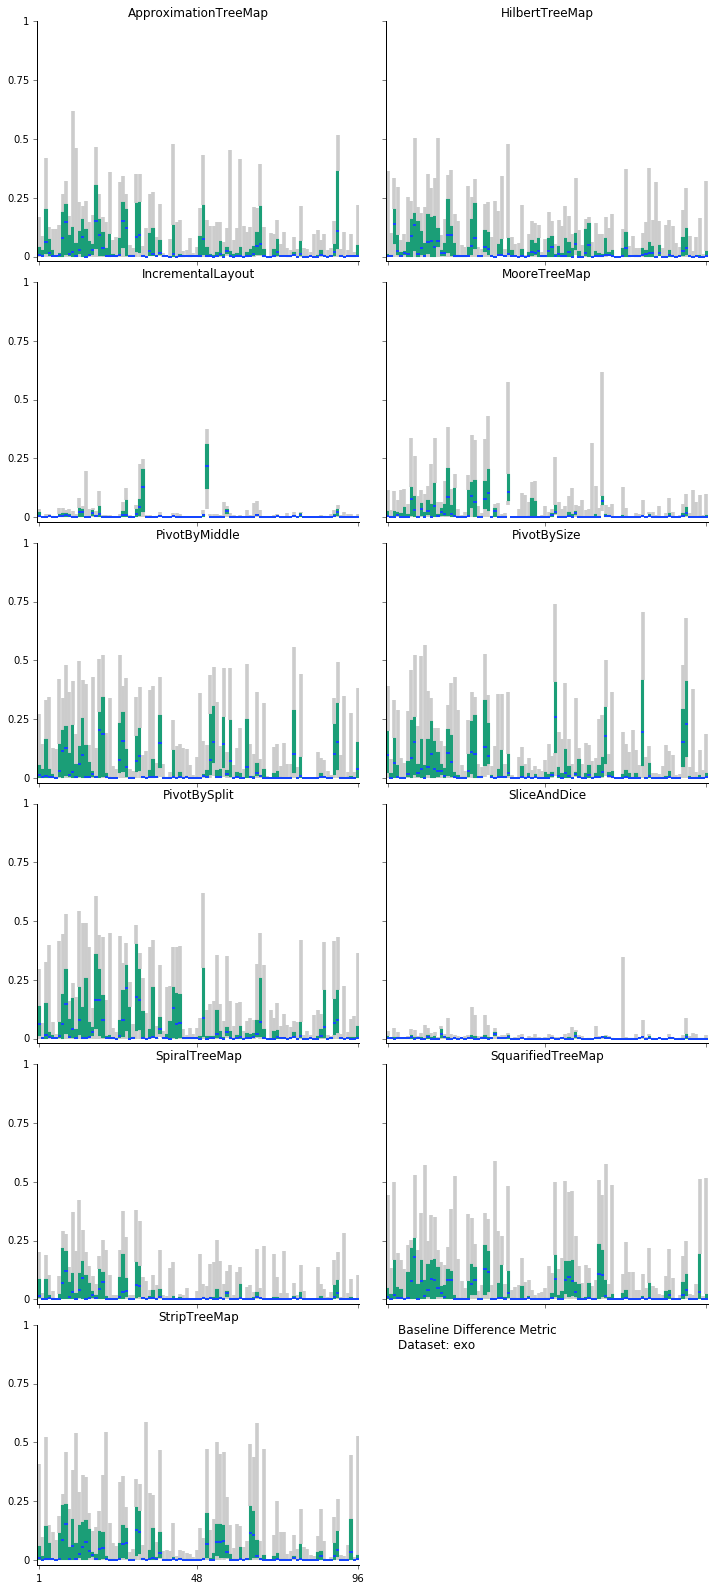

In [126]:
nrow = 6
ncol = 2
fig, axs = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(10, 22))
fig.tight_layout()

for i, ax in enumerate(fig.axes):
    if i != 11:
        technique = technique_ids[i]
        ax.set_title(technique)
        print(technique)

        data = []
        for revision in range(n_revisions - 1):
            bs = baseline_diff_stability(rectangles[technique][revision][['rx', 'ry', 'rw', 'rh']], 
                                    rectangles[technique][revision + 1][['rx', 'ry', 'rw', 'rh']],
                                    rectangles[technique][revision + 1][['bx', 'by', 'bw', 'bh']])
            data.append(bs)

        bp = ax.boxplot(data, whis=[5, 95], showfliers=False, patch_artist=True, widths=1);

        ax.set_ylim(ymin=-0.02, ymax=1)
        ax.set_yticks([0, .25, .5, .75, 1], minor=False)
        ax.set_yticklabels([0, .25, .5, .75, 1], fontdict=None, minor=False)
        styleBoxplot(bp, ax, len(data))
    
s = "Baseline Difference Metric\nDataset: " + dataset_id
fig.axes[11].text(4, .9, s, fontsize=12)
# Remove extra spines and ticks
fig.axes[11].spines['top'].set_visible(False)
fig.axes[11].spines['bottom'].set_visible(False)
fig.axes[11].spines['left'].set_visible(False)
fig.axes[11].spines['right'].set_visible(False)
fig.axes[11].tick_params(axis='x', which='both', top='off', bottom='off', labelbottom='off')
fig.axes[11].tick_params(axis='y', which='both', right='off', left='off')
    
fig.savefig('./boxplots/svg/' + dataset_id + "_bds" + '.svg')
fig.savefig('./boxplots/png/' + dataset_id + "_bds" + '.png')


ApproximationTreeMap
HilbertTreeMap
IncrementalLayout


/usr/lib/python3/dist-packages/numpy/lib/function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)
/usr/lib/python3/dist-packages/matplotlib/cbook.py:2052: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/usr/lib/python3/dist-packages/matplotlib/cbook.py:2059: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/usr/lib/python3/dist-packages/matplotlib/cbook.py:2067: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/usr/lib/python3/dist-packages/matplotlib/cbook.py:2068: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


MooreTreeMap
PivotByMiddle
PivotBySize
PivotBySplit
SliceAndDice
SpiralTreeMap
SquarifiedTreeMap
StripTreeMap


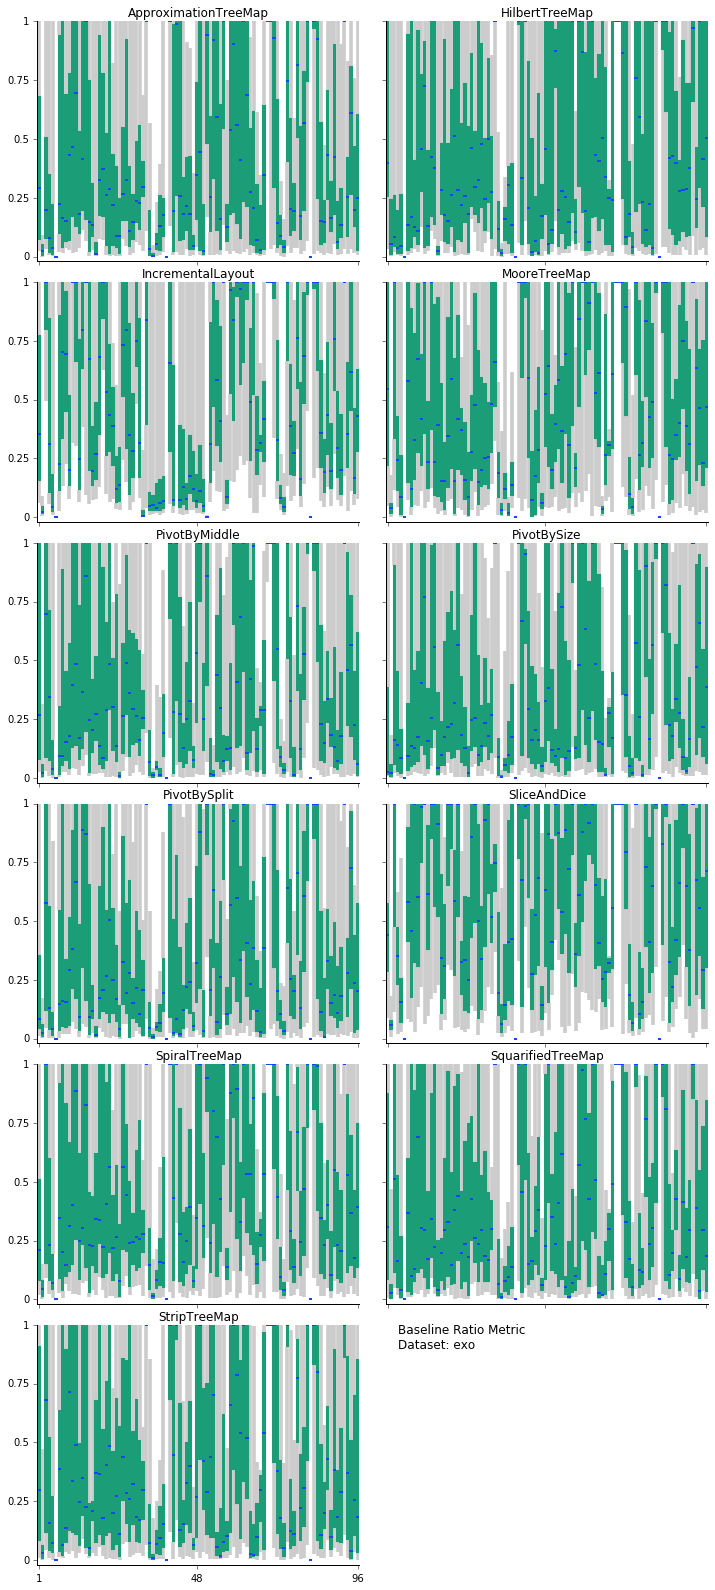

In [128]:
nrow = 6
ncol = 2
fig, axs = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(10, 22))
fig.tight_layout()

for i, ax in enumerate(fig.axes):
    if i != 11:
        technique = technique_ids[i]
        ax.set_title(technique)
        print(technique)

        data = []
        for revision in range(n_revisions - 1):
            bs = baseline_ratio_stability(rectangles[technique][revision][['rx', 'ry', 'rw', 'rh']], 
                                    rectangles[technique][revision + 1][['rx', 'ry', 'rw', 'rh']],
                                    rectangles[technique][revision + 1][['bx', 'by', 'bw', 'bh']])
            data.append(bs)

        bp = ax.boxplot(data, whis=[5, 95], showfliers=False, patch_artist=True, widths=1);

        ax.set_ylim(ymin=-0.02, ymax=1)
        ax.set_yticks([0, .25, .5, .75, 1], minor=False)
        ax.set_yticklabels([0, .25, .5, .75, 1], fontdict=None, minor=False)
        styleBoxplot(bp, ax, len(data))
    
s = "Baseline Ratio Metric\nDataset: " + dataset_id
fig.axes[11].text(4, .9, s, fontsize=12)
# Remove extra spines and ticks
fig.axes[11].spines['top'].set_visible(False)
fig.axes[11].spines['bottom'].set_visible(False)
fig.axes[11].spines['left'].set_visible(False)
fig.axes[11].spines['right'].set_visible(False)
fig.axes[11].tick_params(axis='x', which='both', top='off', bottom='off', labelbottom='off')
fig.axes[11].tick_params(axis='y', which='both', right='off', left='off')
    
fig.savefig('./boxplots/svg/' + dataset_id + "_brs" + '.svg')
fig.savefig('./boxplots/png/' + dataset_id + "_brs" + '.png')
